# **CONFIGURATION**

In [1]:
from google.colab import drive
import os

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!cp drive/MyDrive/MMDS_Data/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [4]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [5]:
import findspark
findspark.init()

In [6]:
import pyspark as spark
from pyspark import SparkContext
sc = SparkContext('local', 'Final')

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Final project") \
    .getOrCreate()

In [8]:
from pyspark.sql import SQLContext

sqlc = SQLContext(sc)

## Spark library

In [9]:
# Request 1 library
from pyspark.sql.types import StructType, StructField, \
IntegerType,DoubleType, FloatType
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors as MLVectors, VectorUDT
from pyspark.ml.feature import VectorAssembler,MinMaxScaler, \
IndexToString, StringIndexer, VectorIndexer
from pyspark.sql.functions import when, col,udf,avg,explode


# Request 2 library
from pyspark.mllib.linalg import Vectors as LibVectors
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.sql import Row


# Request 3 library
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS


# Request 4 library
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator, \
MulticlassClassificationEvaluator


# Request 5 library
from pyspark.ml.classification import \
MultilayerPerceptronClassifier, LinearSVC, RandomForestClassifier
from pyspark.ml import Pipeline


## Normal library

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import numpy as np

## Path to data

In [11]:
PATH_MNIST = "/content/mnist_mini.csv"
PATH_PREDICTION = "/content/result_prediction_MNIST.csv"
PATH_RATING = "/content/ratings2k.csv"
PATH_STOCK = "/content/stockHVN2022.csv"

# **YC 1**

## MNISTDataAnalyzer Class

In [12]:
class MNISTDataAnalyzer:
    def __init__(self, file_path,spark,num_pixel=784):

        self.num_pixel=num_pixel

        self.spark =spark
        schema = StructType([
            StructField("label", IntegerType(), True)] +
            [StructField(f"feature_{i}", IntegerType(), True)\
             for i in range(num_pixel)]
        )

        # Đọc dữ liệu từ tập tin và lưu trữ trong DataFrame
        self.df = self.spark\
                      .read\
                      .csv(file_path, header=False, schema=schema)
        self.clustered=None
        self.model=None
        self.k=None

    def explore_data(self):
        # Hiển thị thông tin về DataFrame
        print("Hiển thị 5 hàng đầu tiên của DataFrame:")
        self.df.show(5)

        # Hiển thị số lượng hàng của DataFrame
        print(f"Số hàng của DataFrame: {self.df.count()}")

        # Vẽ ảnh của một số ký số
        print("Vẽ ảnh của một số ký số:")
        for i in [0, 1, 2, 3, 4,5,6]:
            image = self.df\
                        .filter(self.df.label == i)\
                        .first()\
                        .asDict()
            features = [image[f"feature_{j}"]\
                        for j in range(self.num_pixel)]
            image_arr = np.array(features).reshape(28, 28)
            plt.figure(figsize=(4, 4))
            plt.imshow(image_arr, cmap='gray')
            plt.title(f"Ký số {i}")
            plt.show()

    def run_kmeans(self, k=10, weighted_indices=\
            [0, 1, 2, 3, 4, 7, 8, 11, 18, 61], weight_value=100):
        feature_cols = [f"feature_{i}" for i in range(self.num_pixel)]

        weighted_df= self.df
        # Gộp 784 feature thành 1
        assembler = VectorAssembler(inputCols=feature_cols,
                                    outputCol="features")
        weighted_df = assembler.transform(weighted_df)
        #chuẩn hóa bằng MinMaxScaler
        scaler = MinMaxScaler(inputCol="features",
                              outputCol="scaledFeatures")
        weighted_df = scaler.fit(weighted_df).transform(weighted_df)

        weighted_df= weighted_df.select("label","scaledFeatures")

        query = "SELECT label, scaledFeatures, row_number() "
        query += "over (order by 1) as id "
        query += "FROM weighted_df"

        # Gán ID/Index cho các hàng dữ liệu
        weighted_df.createOrReplaceTempView("weighted_df")
        weighted_df = self.spark\
                          .sql(query)

        # Gán trọng số cho các hàng được chỉ định
        weighted_df = weighted_df.withColumn("weightCol",\
         when((weighted_df["id"]-1)\
              .isin(weighted_indices), weight_value)
              .otherwise(1.0))


        # Huấn luyện mô hình k-means
        kmeans = KMeans(k=k, featuresCol="scaledFeatures")
        kmeans.setWeightCol("weightCol")
        self.model = kmeans.fit(weighted_df)

        clusters = self.model.transform(weighted_df)
        self.clustered=clusters
        self.k=k

    def visualization(self):

        # add centroid column to the dataframe
        centroids = self.model.clusterCenters()
        centroids_df = self.spark.createDataFrame(\
         [list(map(float, c)) for c in centroids], "array<double>")
        centroids_df.createOrReplaceTempView("centroids_df")

        query = "SELECT value, row_number() "
        query += "over (order by 1) as clusters "
        query += "FROM centroids_df"

        # Gán số thứ tự đại diện cho các Clusters
        centroids_df = self.spark.sql(query)

        # UDF dùng để tính khoảng cách các điểm dữ liệu đến centroid
        distance_to_centroid_udf =\
         udf(lambda x, y:
             float(MLVectors.squared_distance(x, y) ** 0.5),\
             DoubleType())

        # Tính khoảng cách đến centroid cho tất cả các điểm dữ liệu
        distance_to_centroid = self.clustered \
                .join(centroids_df, self.\
                      clustered.prediction == col("clusters")-1, "left")\
                .withColumn('distance_to_centroid',
                            distance_to_centroid_udf(\
                            col('scaledFeatures'), col('value'))) \
                .select('prediction', 'distance_to_centroid')

        # Tính trung bình khoảng cách
        avg_distance = distance_to_centroid \
            .select('prediction', 'distance_to_centroid') \
            .groupBy('prediction') \
            .agg(avg('distance_to_centroid').alias('avg_distance'))\
            .orderBy('prediction')

        # Biểu diễn kết quả lên biểu đồ cột
        avg_distance_array = avg_distance\
                                        .select("avg_distance")\
                                        .collect()
        avg_distance_array =\
         [row.avg_distance for row in avg_distance_array]
        # Vẽ biểu đồ cột
        plt.figure(figsize=(10, 6))
        plt.bar(range(self.k), avg_distance_array)
        plt.xlabel("Cluster")
        plt.ylabel("Trung bình khoảng cách")
        plt.\
        title("Khoảng cách trung bình từ các điểm dữ liệu đến centroid")
        plt.show()
        return avg_distance

    def correct_predictions(self):
        correct = self.clustered\
        .where(self.clustered.label == self.clustered.prediction)\
        .count()
        return correct


In [13]:
analyzer = MNISTDataAnalyzer(PATH_MNIST,spark,784)
analyzer.run_kmeans()

In [14]:
analyzer.clustered.show()
correct_predictions = analyzer.correct_predictions()
print("number of correct prediction are ",correct_predictions)
analyzer.clustered\
        .select("id","weightCol","label", "prediction")\
        .repartition(1)\
        .write.csv("result_prediction_MNIST.csv",\
                   header=True, mode="overwrite")

+-----+--------------------+---+---------+----------+
|label|      scaledFeatures| id|weightCol|prediction|
+-----+--------------------+---+---------+----------+
|    7|(784,[0,1,2,3,4,5...|  1|    100.0|         5|
|    2|(784,[0,1,2,3,4,5...|  2|    100.0|         1|
|    1|(784,[0,1,2,3,4,5...|  3|    100.0|         8|
|    0|(784,[0,1,2,3,4,5...|  4|    100.0|         0|
|    4|(784,[0,1,2,3,4,5...|  5|    100.0|         3|
|    1|(784,[0,1,2,3,4,5...|  6|      1.0|         8|
|    4|(784,[0,1,2,3,4,5...|  7|      1.0|         5|
|    9|(784,[0,1,2,3,4,5...|  8|    100.0|         3|
|    5|(784,[0,1,2,3,4,5...|  9|    100.0|         2|
|    9|(784,[0,1,2,3,4,5...| 10|      1.0|         5|
|    0|(784,[0,1,2,3,4,5...| 11|      1.0|         0|
|    6|(784,[0,1,2,3,4,5...| 12|    100.0|         2|
|    9|(784,[0,1,2,3,4,5...| 13|      1.0|         5|
|    0|(784,[0,1,2,3,4,5...| 14|      1.0|         0|
|    1|(784,[0,1,2,3,4,5...| 15|      1.0|         9|
|    5|(784,[0,1,2,3,4,5...|

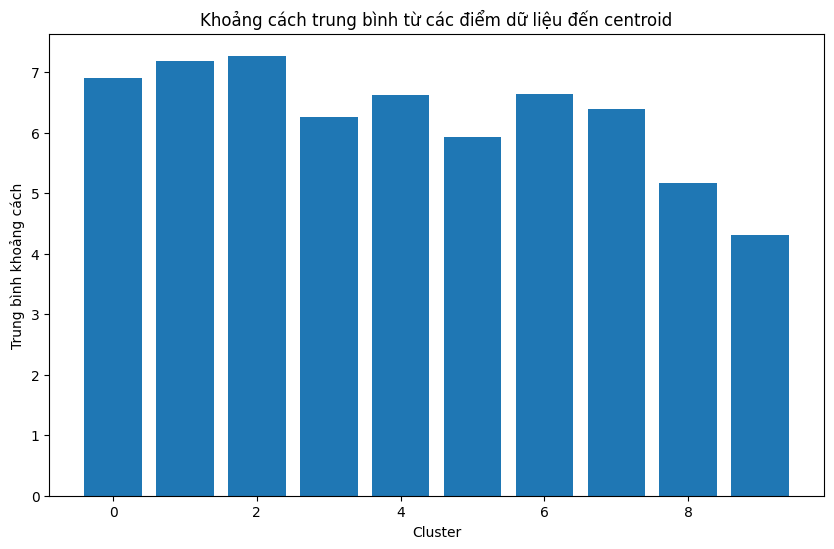

+----------+------------------+
|prediction|      avg_distance|
+----------+------------------+
|         0| 6.907217851505635|
|         1|  7.17482708159577|
|         2| 7.268605945537409|
|         3| 6.263872700343862|
|         4|6.6178685871974805|
|         5| 5.931458046250229|
|         6| 6.644184549555971|
|         7| 6.383846271092985|
|         8| 5.161527818246323|
|         9| 4.300263656588253|
+----------+------------------+



In [15]:
avg_predict=analyzer.visualization()
avg_predict.show()

# **YC 2**

## SVD class

In [16]:
class SVD():

  def __init__(self, svd=None):
    self.df = None
    self.label_df = None
    self.U_df = None
    self.data = None
    self.plot_data = None
    self.svd = svd

  def read_data(self, path):
    '''
    Read mnist_mini.csv file
    path: path to the file
    '''
    self.df = spark.read.csv(path, header=False, inferSchema=True)

  def read_prediction(self, path):
    '''
    Read prediction result from request 1
    path: path to result file (csv file)
    '''
    self.label_df = spark.read.csv(path, header=True, inferSchema=True)

  def calculate_svd(self):
    '''
    r always equals to 3 (To plot in 3D scatter plot)
    '''

    if self.svd != None:
      print("Already provided svd. Skipping this method...")
      return

    if self.df == None:
      print("No data to continue")
      return

    number_of_columns = len(self.df.columns)

    df = self.df

    rdd = df.rdd.map(lambda row: \
    LibVectors.dense([row[f"_c{i}"] for i in range(number_of_columns)]))

    mat = RowMatrix(rdd)

    svd = mat.computeSVD(3, computeU=True)

    self.svd = svd

    if(self.svd != None):
      print("Successfully calculate SVD")
    else :
      print("Error when calculating SVD")

  def get_U(self):
    '''Left singular vector (m x r)'''
    if self.svd == None:
      print("No data to get U.Please check again")
      return

    U = self.svd.U
    self.U_df = U.rows.map(lambda row: Row(*(float(x)\
     for x in row.toArray()))).toDF(["x", "y", "z"])

  def get_data(self):
    '''
    Collect data after svd.
    Data is small because it just have 3 dimension for each row
    '''

    if self.label_df == None:
      print("Please provide label of data first")
      return

    if self.U_df == None:
      print("Please get U matrix first")
      return

    label_df = self.label_df

    collect_U = self.U_df.collect()
    collect_prediction = label_df.\
    select(label_df['prediction']).collect()

    result_U = [list(row) for row in collect_U]
    result_prediction = [list(row) for row in collect_prediction]

    result_merge = []

    for i in range(len(result_U)):
      row = result_U[i]
      row.append(result_prediction[i][0])

      result_merge.append(row)

    self.data = result_merge

  def get_data_to_plot(self, n):
    '''
    Get random {n} rows of data to plot
    n : number of points to plot into 3D scatter plot
    '''
    if(self.data == None):
      print("Does not have data to plot")
      return

    if(n > len(self.data)):
      print("n must < {}".format(self.data))

    self.plot_data = random.sample(self.data, n)

  def plot(self):
    '''
    Plot data in 3D scatter plot
    '''

    if(self.plot_data == None):
      print("Does not have data to plot")
      return

    x_coords = [item[0] for item in self.plot_data]
    y_coords = [item[1] for item in self.plot_data]
    z_coords = [item[2] for item in self.plot_data]
    labels = [item[3] for item in self.plot_data]

    colors = ['red', 'blue', 'green', 'orange',\
     'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = set()

    for i, label in enumerate(labels):
      if label not in unique_labels:
        ax.scatter(x_coords[i], y_coords[i], \
        z_coords[i], color=colors[label], label=str(label))
        unique_labels.add(label)
      else:
        ax.scatter(x_coords[i], y_coords[i],\
          z_coords[i], color=colors[label])


    ax.legend(title="Nhãn")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Biều đồ 3D thể hiện phân bố các điểm')

    plt.show()



## Evaluate

In [17]:
obj = SVD()
obj.read_data(PATH_MNIST)
obj.read_prediction(PATH_PREDICTION)

In [18]:
obj.calculate_svd()
obj.get_U()

Successfully calculate SVD


In [19]:
obj.get_data()

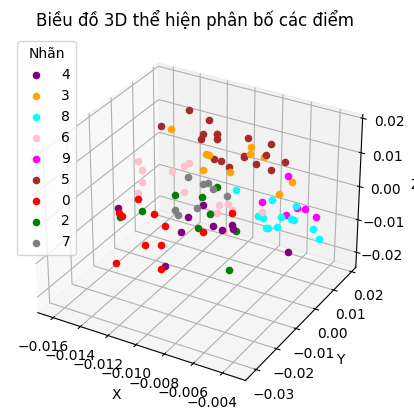

In [20]:
obj.get_data_to_plot(100)
obj.plot()

# **YC 3**

## CollaborativeFilteringModel class

In [21]:
class CollaborativeFilteringModel:
    def __init__(self, ratings_file,sqlc):
        self.spark = sqlc
        self.ratings_file = ratings_file
        self.model = None
        self.training_data = None
        self.test_data = None

    def load_and_split_data(self, test_ratio=0.3):
        data = self.spark.read.csv(self.ratings_file, \
                                   header=True, inferSchema=True)
        (self.training_data, self.test_data) = data\
        .randomSplit([1 - test_ratio, test_ratio])

    def train_model(self, rank, max_iter=10, reg_param=0.1):
        als = ALS(maxIter=max_iter,
                  regParam=reg_param,
                  rank=rank,
                  userCol="user",
                  itemCol="item",
                  ratingCol="rating",
                  coldStartStrategy="drop")
        self.model = als.fit(self.training_data)

    def evaluate_model(self):
        # Đánh giá trên tập train
        train_predictions = self.model.transform(self.training_data)
        train_evaluator = RegressionEvaluator(metricName="mse",
                                              labelCol="rating",
                                              predictionCol="prediction")
        train_mse = train_evaluator.evaluate(train_predictions)

        # Đánh giá trên tập test
        test_predictions = self.model.transform(self.test_data)
        test_evaluator = RegressionEvaluator(metricName="mse",
                                             labelCol="rating",
                                             predictionCol="prediction")
        test_mse = test_evaluator.evaluate(test_predictions)

        return train_mse, test_mse

    def plot_mse(self, train_mse_values, test_mse_values):
        ranks = list(range(10, 21))
        n = len(ranks)

        # Tạo vị trí cho các nhóm cột
        index = np.arange(n)
        bar_width = 0.35  # Độ rộng của mỗi cột

        plt.figure(figsize=(12, 6))

        # Vẽ cột cho Train MSE
        plt.bar(index,
                train_mse_values,
                bar_width,
                label='Train MSE',
                color='b')

        # Vẽ cột cho Test MSE
        plt.bar(index + bar_width,
                test_mse_values,
                bar_width,
                label='Test MSE',
                color='r')

        plt.xlabel('Rank')
        plt.ylabel('Mean Squared Error (MSE)')
        plt.title('MSE vs. Rank for Train and Test Data')

        # Đặt các nhãn trục x
        plt.xticks(index + bar_width / 2, ranks)

        plt.legend()
        plt.grid(True)
        plt.show()
    def recommend_for_user(self, user_id, num_recommendations=5):
        # Tạo DataFrame chứa một người dùng
        user_subset = self.spark.createDataFrame([(user_id,)], ["user"])

        # Lấy khuyến nghị cho người dùng
        recommendations = self.model\
        .recommendForUserSubset(user_subset, num_recommendations)

        # Dùng explode để bung các khuyến nghị thành các hàng riêng biệt
        recommendations = recommendations\
        .select("user", explode("recommendations")\
                .alias("recommendation"))

        # Tách cột recommendation thành movieId và rating
        recommendations = recommendations\
        .select("user", "recommendation.item", "recommendation.rating")

        # Hiển thị khuyến nghị
        recommendations.show(truncate=False)

    def run(self):
        self.load_and_split_data()
        train_mse_values = []
        test_mse_values = []

        for rank in range(10, 21):
            self.train_model(rank)
            train_mse, test_mse = self.evaluate_model()
            train_mse_values.append(train_mse)
            test_mse_values.append(test_mse)
            print('Rank: {}, Train MSE: {}, Test MSE: {}'\
                  .format(rank, train_mse, test_mse))

        self.plot_mse(train_mse_values, test_mse_values)
        # Run inference for a specific user
        self.recommend_for_user(user_id=1)
        self.recommend_for_user(user_id=5)



## Evaluate

Rank: 10, Train MSE: 0.06708341164139786, Test MSE: 1.102685237296154
Rank: 11, Train MSE: 0.06444321235050869, Test MSE: 1.0559586790581634
Rank: 12, Train MSE: 0.06171998415553504, Test MSE: 1.0815406188628092
Rank: 13, Train MSE: 0.06169335177447998, Test MSE: 1.1223171816751614
Rank: 14, Train MSE: 0.06012348159494676, Test MSE: 1.0605907158387717
Rank: 15, Train MSE: 0.0583612598271732, Test MSE: 1.0941482974015135
Rank: 16, Train MSE: 0.05915158472605479, Test MSE: 1.083363863880489
Rank: 17, Train MSE: 0.05836597502151509, Test MSE: 1.091590804145277
Rank: 18, Train MSE: 0.057441982862285246, Test MSE: 1.0844843808938136
Rank: 19, Train MSE: 0.05847027367234166, Test MSE: 1.0679764044534739
Rank: 20, Train MSE: 0.05780062772701523, Test MSE: 1.0816960655039942


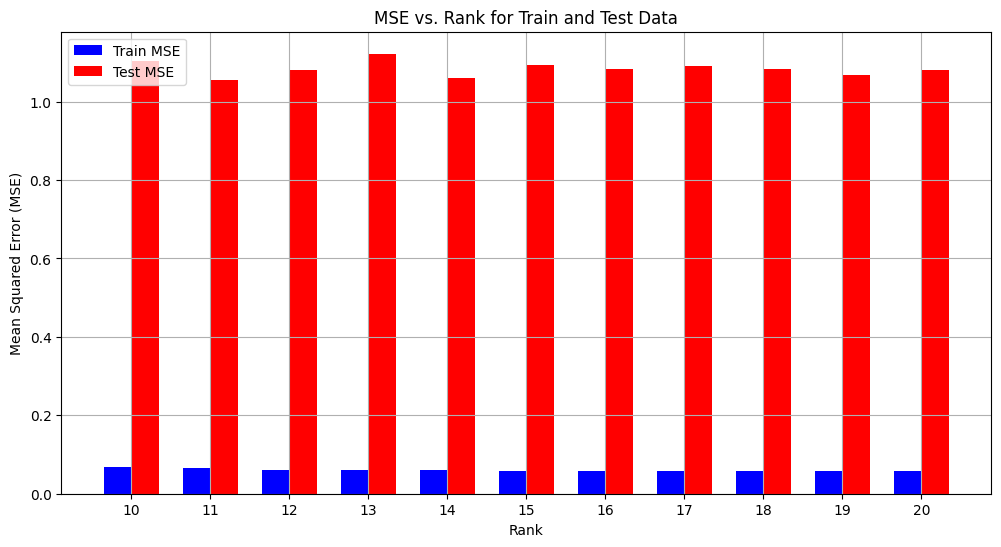

+----+----+---------+
|user|item|rating   |
+----+----+---------+
|1   |163 |4.9111366|
|1   |352 |4.885433 |
|1   |168 |4.8064146|
|1   |413 |4.672568 |
|1   |301 |4.5208135|
+----+----+---------+

+----+----+---------+
|user|item|rating   |
+----+----+---------+
|5   |187 |4.9392447|
|5   |28  |4.797539 |
|5   |340 |4.7767954|
|5   |437 |4.738881 |
|5   |80  |4.7317543|
+----+----+---------+



In [23]:
model = CollaborativeFilteringModel(PATH_RATING,sqlc)
model.run()

## **YC 4**

## StockPriceAmplitudePrediction class

In [24]:
class StockPriceAmplitudePrediction:
    def __init__(self, file_path: str,
                 spark: SparkSession | None = None,
                  model=LinearRegression,
                 featuresCol="ampl_Kd_before",
                  labelCol="ampl_next",
                 is_percentage: bool = True,
                  K: int = 5,
                 date_col: str = "Ngay",
                 price_col: str = "HVN"):
        self.spark = spark or SparkSession\
        .builder.appName("StockPriceAmplitudePrediction").getOrCreate()
        self.model = model
        self.file_path = file_path
        self.df = None
        self.training_data = None
        self.testing_data = None
        self.featuresCol = featuresCol
        self.labelCol = labelCol
        self.date_col = date_col
        self.price_col = price_col
        self.test_predictions = None
        self.is_percentage = is_percentage
        self.K = K

    def extract(self):
        df = self.spark.read.csv(self.file_path,
                                      header=True,
                                      inferSchema=True)
        df = df.withColumn(self.date_col,
                           F.to_date(df[self.date_col],
                                     "dd/MM/yyyy"))
        self.df = df

    def plot_data(self, NO_ROWS_TO_SHOW:int=10000,
                  title:str="Stock Graph"):
        # 219 rows for this dataset
        df_np = self.df.select(self.date_col, self.price_col) \
            .limit(NO_ROWS_TO_SHOW).collect()
        df_np = np.array(df_np)
        plt.figure(figsize=(16, 4))
        plt.plot(df_np[:, 0], df_np[:, 1])
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.title(title)
        plt.grid()
        plt.show()

    def transform(self):
        # _calculate_amplitude = lambda price, prev_price: \
        #     float((price - prev_price) / prev_price) * \
        #         (100 * self.is_percentage or 1) if prev_price else 0.0
        # calculate the fluctuation amplitude following the formula

        df = self.df
        window = Window.orderBy(self.date_col)
        amplitude_col = F.col(self.price_col)\
         - F.lag(self.price_col).over(window)
        amplitude_col = amplitude_col / F.lag(self.price_col).\
        over(window)\
         * (100 * self.is_percentage or 1)
        df = df.withColumn("fluctuation",
                           F.when(F.lag(self.price_col)\
                                  .over(window).isNull(), 0.0)\
                           .otherwise(amplitude_col))

        # generate a new DataFrame containing 2 columns
        df = df.withColumn("ampl_Kd_before",
                          F.array([F.lag("fluctuation", i, 0) \
                          .over(Window.orderBy(self.date_col)) \
                           for i in range(1, self.K+1)]))
        dense_vec_udf = F.udf(lambda x:\
                              MLVectors.dense(x), VectorUDT())
        df = df.withColumn("ampl_Kd_before",
                           dense_vec_udf(F.col("ampl_Kd_before")))
        df = df.withColumn("ampl_next", F.col("fluctuation"))

        # divide the data into training and testing sets
        self.training_data = df.\
        filter(F.month(F.col(self.date_col)) <= 6)
        self.testing_data = df.\
        filter(F.month(F.col(self.date_col)) > 6)
        self.df = df

    def train(self):
        my_model = self.model(featuresCol=self.featuresCol,
                              labelCol=self.labelCol)

        my_model = my_model.fit(self.training_data)

        self.model = my_model

    def evaluate(self, metricName: str = "mse"):
        predictions = self.model.transform(self.testing_data)
        predictionCol = self.model.getPredictionCol()
        evaluator = RegressionEvaluator(labelCol=self.labelCol,
                                        predictionCol=predictionCol,
                                        metricName=metricName)

        loss_train = self.model.evaluate(self.training_data)\
        .meanSquaredError
        loss_test = evaluator.evaluate(predictions)

        self.test_predictions = predictions

        return loss_train, loss_test

    def visualize_evaluation(self, loss_train: float, loss_test: float):
        plt.bar(["Training", "Testing"],
         [loss_train, loss_test], color=["c", "m"])
        for i, v in enumerate([loss_train, loss_test]):
          plt.text(i,
                   v,
                   f"{v:.6f} " + (" - sqr(%)" \
                                  if self.is_percentage else ""),
                   ha="center",
                   va="bottom")

        plt.xlabel("Dataset")
        plt.ylabel("MSE" + " - sqr(%)" if self.is_percentage else "")
        plt.title("MSE of Training and Testing sets")

        plt.show()

    def run(self):
        self.extract()
        self.transform()
        self.train()

## Run the pipeline

In [25]:
stock_price_prediction = \
StockPriceAmplitudePrediction(PATH_STOCK,
                              is_percentage=False,
                              spark=spark)
stock_price_prediction.run()

### Plot the stock price input data

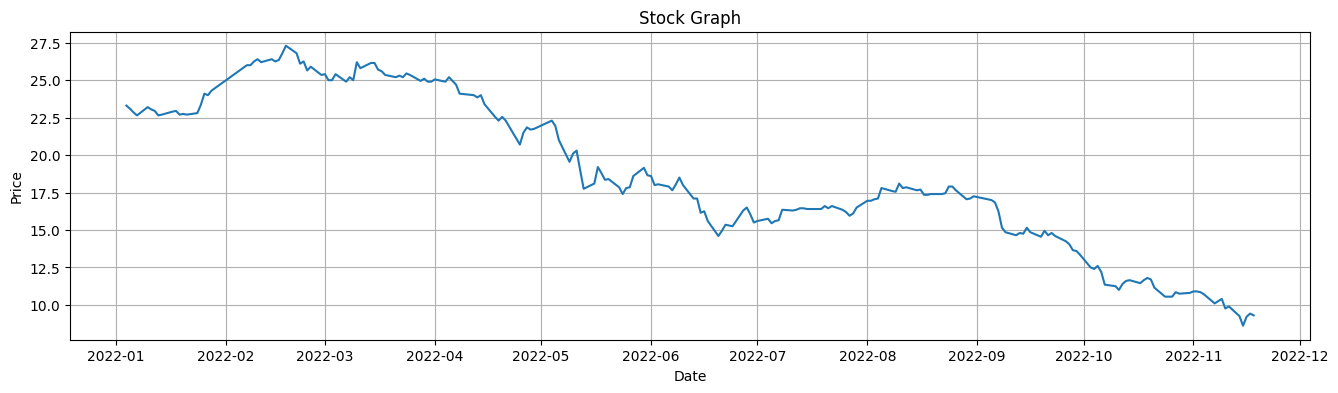

In [26]:
stock_price_prediction.plot_data()

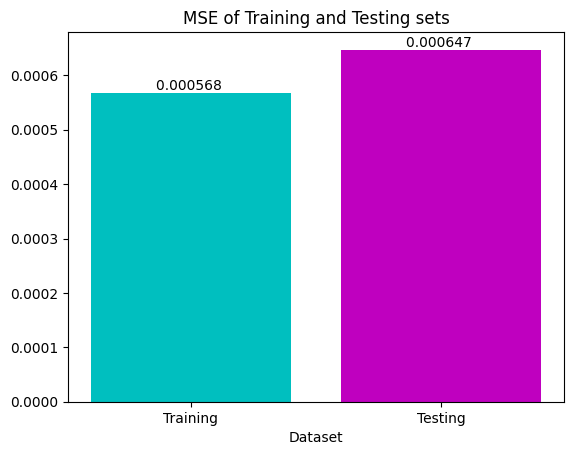

In [27]:
loss_train, loss_test = stock_price_prediction.evaluate()
stock_price_prediction.visualize_evaluation(loss_train, loss_test)

### Show the prediction results

In [28]:
stock_price_prediction.test_predictions.show()

+----------+-----+--------------------+--------------------+--------------------+--------------------+
|      Ngay|  HVN|         fluctuation|      ampl_Kd_before|           ampl_next|          prediction|
+----------+-----+--------------------+--------------------+--------------------+--------------------+
|2022-07-01| 15.6|0.006451612903225784|[-0.0342679127725...|0.006451612903225784|0.008579916685473676|
|2022-07-04|15.75|0.009615384615384638|[0.00645161290322...|0.009615384615384638|0.004753977842311...|
|2022-07-05|15.45|-0.01904761904761...|[0.00961538461538...|-0.01904761904761...|-0.00777426943257257|
|2022-07-06| 15.6|0.009708737864077693|[-0.0190476190476...|0.009708737864077693|-0.01118983966620...|
|2022-07-07|15.65|0.003205128205128...|[0.00970873786407...|0.003205128205128...|0.003307230591493...|
|2022-07-08|16.35|  0.0447284345047924|[0.00320512820512...|  0.0447284345047924|-0.00332000399618021|
|2022-07-11| 16.3|-0.00305810397553...|[0.04472843450479...|-0.0030581039

# **YC 5**

## Read data

In [29]:
data = spark.read.csv(PATH_MNIST, header=False, inferSchema=True)

## ClassificationProblem class

In [30]:
class ClassificationProblem:
    def __init__(self):
      self.models = {
          'MLP': None,
          'RF': None,
          'LSVC': None
      }
      self.data = None;
      self.train_data = None;
      self.test_data = None;
      self.train_data_LSVC = None;
      self.test_data_LSVC = None;

    def create_model(self):

      self.models['MLP'] = self.create_model_MLP();
      self.models['RF'] = self.create_model_RF();
      self.models['LSVC'] = self.create_model_LSVC();

    def create_model_MLP(self):

      # Tạo lớp huấn luyện mô hình MLP
      layers = [784, 500, 300, 100, 10]

      MLP = MultilayerPerceptronClassifier(maxIter=100,
                                           layers=layers,
                                           blockSize=128,
                                           seed=1234,
                                           labelCol = "label")

      return MLP

    def create_model_RF(self):

      labelIndexer = StringIndexer(inputCol="label",
                                   outputCol="indexedLabel")\
                                   .fit(self.data)

      featureIndexer =\
          VectorIndexer(inputCol="features",
                        outputCol="indexedFeatures",
                        maxCategories=4).fit(self.data)

      rf = RandomForestClassifier(labelCol="indexedLabel",
                                  featuresCol="indexedFeatures",
                                  numTrees=10)

      labelConverter = IndexToString(inputCol="prediction",
                                     outputCol="predictedLabel",
                                     labels=labelIndexer.labels)

      # Chain indexers and forest in a Pipeline
      pipeline = Pipeline(stages=[labelIndexer,
                                  featureIndexer,
                                  rf,
                                  labelConverter])

      return pipeline

    def create_model_LSVC(self):

      lsvc = LinearSVC(maxIter=100, regParam=0.1)
      return lsvc

    def data_progressing(self):

      validation_col = self.data.columns[0]

      feature_cols = self.data.columns[1:]

      vector_assembler = VectorAssembler(inputCols=feature_cols,
                                         outputCol="features")

      self.data = vector_assembler.transform(self.data)\
      .select(validation_col, "features")
      self.data = self.data\
      .withColumnRenamed(validation_col, "label")

      train_data, test_data = self.data.randomSplit([0.6, 0.4], seed=1234)

      self.train_data = train_data
      self.test_data = test_data

    def data_progressing_LSVC(self):

      # Áp dụng hàm when
      # để chuyển đổi giá trị của cột "label"
      # thành 0 hoặc 1 dựa trên ngưỡng 4.5
      data_transformed_train = self.train_data.\
      withColumn("binary_label",
                 when(self.data["label"] >= 4.5, 1)\
                 .otherwise(0))
      data_transformed_test = self.test_data\
      .withColumn("binary_label",
                  when(self.data["label"] >= 4.5, 1)\
                  .otherwise(0))

      train_data_LSVC = data_transformed_train\
      .select("binary_label", "features")\
      .withColumnRenamed("binary_label", "label")
      test_data_LSVC = data_transformed_test\
      .select("binary_label", "features")\
      .withColumnRenamed("binary_label", "label")

      self.train_data_LSVC = train_data_LSVC
      self.test_data_LSVC = test_data_LSVC

    def train(self):

      self.models['MLP'] = self.models['MLP'].fit(self.train_data)
      self.models['RF'] = self.models['RF'].fit(self.train_data)
      self.models['LSVC'] = self.models['LSVC']\
      .fit(self.train_data_LSVC)

    def cross_entropy(self, models_name):

      if models_name != "MLP" and models_name != "RF" :
        return None

      predictions_test = self.models[models_name]\
      .transform(self.train_data)
      epsilon = 1e-15
      N = predictions_test.count()
      C = 10
      Yij = [0] * 10

      label_counts = predictions_test.groupBy("label")\
      .count().orderBy("label")
      counts_array = label_counts.select("count").collect()
      counts_array = [row["count"] for row in counts_array]


      for yij in range(10):
        Yij[yij] = counts_array[yij]/N


      # Lấy cột "probability"
      probabilities = predictions_test.select("probability").collect()
      probabilities = [row["probability"] for row in probabilities]


      cross_entropy = 0

      # Tính cross entropy
      for i in range(N):  # Lặp qua từng mẫu
        for j in range(C):  # Lặp qua từng lớp
          cross_entropy -= Yij[j] * np.log(probabilities[i][j] + epsilon)

      # Chuẩn hóa theo số lượng mẫu
      cross_entropy /= N

      return cross_entropy

    def evaluate(self, model_name):

      if model_name not in self.models:
          return "Không có model này"
      else:
          model = self.models[model_name]

      if model_name == 'LSVC' :
        train_data = self.train_data_LSVC
        test_data = self.test_data_LSVC
      else :
        train_data = self.train_data
        test_data = self.test_data

      # Tạo dự đoán
      predictions_test = model.transform(train_data)
      predictions_train = model.transform(test_data)

      if model_name == 'RF':
        evaluator = MulticlassClassificationEvaluator(
            labelCol="indexedLabel",
            predictionCol="prediction",
            metricName="accuracy")
      else:
        evaluator = MulticlassClassificationEvaluator(
            labelCol="label",
            predictionCol="prediction",
            metricName="accuracy")

      test_data_accuracy = evaluator.evaluate(predictions_test)
      train_data_accuracy = evaluator.evaluate(predictions_train)

      return test_data_accuracy, train_data_accuracy

    def run(self, data):
      self.data = data;
      self.data_progressing();
      self.data_progressing_LSVC();
      self.create_model();
      self.train();


## Init and train models

In [31]:
problem = ClassificationProblem()
problem.run(data)

## Evaluate models

In [32]:
test_accuracy_MLP, train_accuracy_MLP = problem.evaluate('MLP')
test_accuracy_RF, train_accuracy_RF = problem.evaluate('RF')
test_accuracy_LSVC, train_accuracy_LSVC = problem.evaluate('LSVC')

print("Cross entropy MLP: ", problem.cross_entropy('MLP'))
print("Cross entropy RF: ", problem.cross_entropy('RF'))

Cross entropy MLP:  11.574941172167913
Cross entropy RF:  3.1499912205071867


## Plot model accuracy

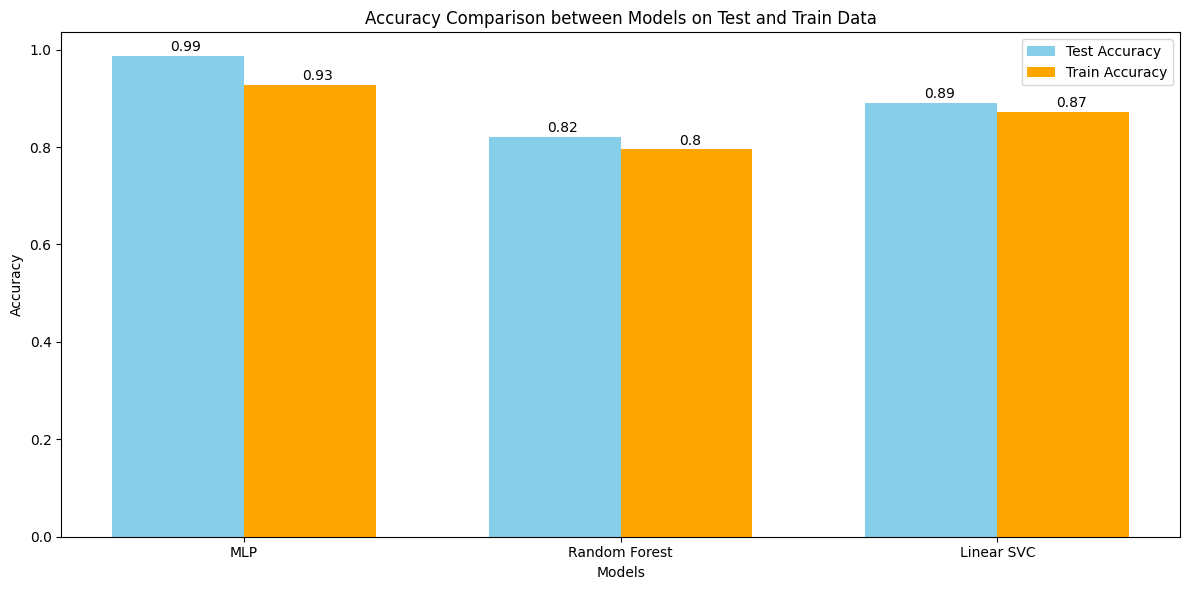

In [33]:
models = ['MLP', 'Random Forest', 'Linear SVC']

test_accuracies = [
    test_accuracy_MLP,
    test_accuracy_RF,
    test_accuracy_LSVC]
train_accuracies = [
    train_accuracy_MLP,
    train_accuracy_RF,
    train_accuracy_LSVC]

bar_width = 0.35

index = np.arange(len(models))

plt.figure(figsize=(12, 6))  # Tăng kích thước hình ảnh

plt.bar(
    index,
    test_accuracies,
    bar_width,
    color='skyblue',
    label='Test Accuracy')

plt.bar(
    index + bar_width,
    train_accuracies,
    bar_width,
    color='orange',
    label='Train Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison between Models on Test and Train Data')

plt.xticks(index + bar_width / 2, models)

for i in range(len(models)):
    plt.text(
        index[i] - 0.02,
        test_accuracies[i] + 0.01,
        str(round(test_accuracies[i], 2)),
        color='black')
    plt.text(
        index[i] + bar_width - 0.02,
        train_accuracies[i] + 0.01,
        str(round(train_accuracies[i], 2)),
        color='black')


plt.legend()

plt.tight_layout()
plt.show()